In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# OLS GLM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import defaultdict
from scipy.stats import chi2_contingency, ttest_ind
from scipy.stats import norm, beta

# Resampling
from os.path import exists
from scipy.stats import t, bootstrap

# B_Spline
from patsy import dmatrices, dmatrix, demo_data

## Question 0 - R-Squared Warmup [20 points]

In this question you will fit a model to the **ToothGrowth data**
used in the notes on Resampling and Statsmodels-OLS. 
- Read the data
- log transform tooth length,
- fit a model with independent variables for supplement type, **dose (as categorical)**, and their interaction. 

Demonstrate how to compute the R-Squared and 
Adjusted R-Squared values and compare your 
computations to the attributes (or properties) 
already present in the result object.

In [2]:
# tooth growth data
file = 'tooth_growth.feather'
if exists(file):
    tg_data = pd.read_feather(file)
else: 
    tooth_growth = sm.datasets.get_rdataset('ToothGrowth')
    #print(tooth_growth.__doc__)
    tg_data = tooth_growth.data
    tg_data.to_feather(file)
# tg_data

In [3]:
tg_data['log_len'] = tg_data[['len']].transform(np.log)
tg_data['dose_cat'] = pd.Categorical(tg_data['dose'])

tg_data['OJ'] = pd.get_dummies(tg_data['supp'])['OJ']

In [4]:
# Fit the model with supplement type, dose (as categorical), and their interaction.
mod1 = sm.OLS.from_formula('log_len ~ OJ*dose_cat', data=tg_data)
res1 = mod1.fit()
res1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:               OLS              Adj. R-squared:     0.775   
Dependent Variable:  log_len          AIC:                3.4775  
Date:                2021-11-05 15:04 BIC:                16.0436 
No. Observations:    60               Log-Likelihood:     4.2612  
Df Model:            5                F-statistic:        41.69   
Df Residuals:        54               Prob (F-statistic): 2.34e-17
R-squared:           0.794            Scale:              0.056441
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept           2.0208   0.0751 26.8989 0.0000  1.8702  2.1715
dose_cat[T.1.0]     0.7893   0.1062  7.4294 0.0000  0.5763  1.0024
dose_cat[T.2.0]     1.2273   0.1062 11.5513 0.0000  1.0143  1.4403
OJ                  0.5118   0.1062  4.8171 0.0000  0.2988  0.7248
OJ:dose_cat[T.1.0] -0.2148   0.1503 -1.4297 0.1586 -0.5161  0.0864
OJ:dose_cat[T.2.0] -0.5041   0.1503 -3.3551 0.0015 -0.8054 -0.2029
------------------------------------------------------------------
Omnibus:              0.136         Durbin-Watson:           1.862
Prob(Omnibus):        0.934         Jarque-Bera (JB):        0.039
Skew:                 -0.058        Prob(JB):                0.981
Kurtosis:             2.953         Condition No.:           10   
==================================================================

"""

- The R-square can be computed by the division of the sum of squares due to regression $SS_{regression}$ and total sum of squares $SS_{total}$,
$$R^2 = \frac{SS_{regression}}{SS_{total}}$$
where $SS_{regression} = \sum{(y_{predict} - y_{mean})^2}$
and $SS_{total} = \sum{(y_{observe} - y_{mean})^2}$

- The adjusted R-square could be derived by modifing R-square
$Adusted\_R^2 = 1- \frac{(1-R^2) \cdot (n-1)}{n-k-1}$, with n is 
the number of samples and k is the number of variables

In [5]:
# Demonstrate how to compute the R-Squared and Adjusted R-Squared values 
# and compare your computations to the presented in the result object.

# Presented R-Squared and Adjusted R-Squared values 
print('Presented R-squared value is', res1.rsquared)
print('Presented Adjusted R-squared value is', res1.rsquared_adj)

# How to compute R-Squared and Adjusted R-Squared values 
y_hat, r = res1.predict(), res1.resid
X = mod1.exog

y = y_hat + r # y_observation
y_bar = np.sum(y)/len(y)          # or sum(y)/len(y)
SSReg = np.sum(np.square(np.subtract(y_hat,y_bar)))
SST = np.sum(np.square(np.subtract(y,y_bar)))
Rsquared = SSReg/SST
print('The calculated R-squared is', Rsquared)

adj_rsquared = 1 - (1-Rsquared)*(len(y_hat) - 1) / (len(y_hat) - X.shape[1] - 1)
print('The calculated adj_rsquared is', adj_rsquared)

Presented R-squared value is 0.7942457970936073
Presented Adjusted R-squared value is 0.7751944820096821
The calculated R-squared is 0.7942457970936053
The calculated adj_rsquared is 0.7709528684626927


## Question 1 - NHANES Dentition [50 points]

In this question you will use the NHANES dentition and demographics data from problem sets 2 and 4.

### Prob.a [30 points] 
- Pick a single tooth (OHXxxTC) and model the probability that a permanent tooth is present (look up the corresponding statuses) as a function of **age** using logistic regression.
- For simplicity, assume the data are iid and ignore the survey weights and design.
- Use a B-Spline basis to allow the probability to vary smoothly with age. 
- Perform model selection using **AIC** (or another method) to **choose the location of knots** and **the order of the basis** (or just use degree=3 (aka order) and focus on knots).

Control for other demographics included in the data as warranted. 
- You may also select these by minimizing AIC 
or you may choose to include some demographics regardless of whether they improve model fit. 
- Describe your model building decisions and/or selection process and the series of models fit.

Update October 27: When placing knots, be careful not to place knots at ages below (or equal to) the minimum age at which the tooth you are modeling is present in the data. Doing so will lead to an issue known as perfect separation and make your model non-identifiable. To make the assignment easier you may (but are not required to) limit the analyses to those age 12 and older and use no knots below age 14.



In [6]:
# Construction of Demo and Ohx refers to HW2
demo_file = './demo_comb_df.pkl'
demo_df = pd.read_pickle(demo_file)

ohx_file = './oral_comb_df.pkl'
ohx_df = pd.read_pickle(ohx_file)

seed = 2021 * 11 * 3

In [7]:
df = demo_df[['id','age']]
# Select a signle tooth "OHX02TC"
df = pd.merge(df, ohx_df[['id','tc_02']], on='id', how='left')

In [8]:
# limit the analyses to those age 12 and older and use no knots below age 14.
df = df.query('age >= 12')

# Dependent Variable: 
# a permanent tooth is present (look up the corresponding statuses)
# Choose the upper right 2nd molar
permanent_tooth_present = 'Permanent tooth present'
df['tc02_Perm_Pre'] = (df['tc_02']
                      .apply(lambda x: x == permanent_tooth_present)
                      .replace({np.nan: False})
                     )

# Turn True and False to 1/0
df['tc02_Perm_Pre'] = df['tc02_Perm_Pre'].replace(
    {True: 1,
     False: 0
    })

In [9]:
# model 0
mod0 = smf.logit('tc02_Perm_Pre~bs(age, df=5, degree=3)', data=df)
res0 = mod0.fit(disp=True)
res0.summary()

Optimization terminated successfully.
         Current function value: 0.532176
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          tc02_Perm_Pre   No. Observations:                27832
Model:                          Logit   Df Residuals:                    27826
Method:                           MLE   Df Model:                            5
Date:                Fri, 05 Nov 2021   Pseudo R-squ.:                  0.1513
Time:                        15:04:35   Log-Likelihood:                -14812.
converged:                       True   LL-Null:                       -17451.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.8584      0.062     13.809      0.000       0.737       0.980
bs(age, df=5, degree=3)[0]     2.6989      0.142     19.000      0.000       2.420       2.977
bs(age, df=5, degree=3)[1]    -0.0088      0.099     -0.088      0.930      -0.204       0.186
bs(age, df=5, degree=3)[2]     0.0836      0.121      0.690      0.490      -0.154       0.321
bs(age, df=5, degree=3)[3]    -1.6320      0.096    -17.083      0.000      -1.819      -1.445
bs(age, df=5, degree=3)[4]    -1.7323      0.081    -21.372      0.000      -1.891      -1.573
==============================================================================================
"""

Text(0, 0.5, 'Probability of permanent tooth tc_02 present')

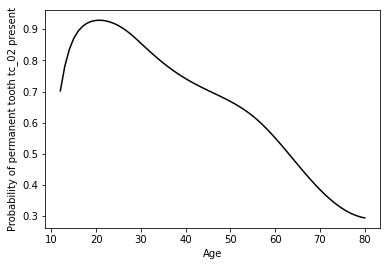

In [10]:
df['predict'] = mod0.predict(params = res0.params, exog=mod0.exog)
Plot_df = df[['age', 'predict']].sort_values(by=['age']).drop_duplicates()
x_var = np.array(Plot_df['age'])
y_var = np.array(Plot_df['predict'])
plt.plot(x_var, y_var, color='k')
plt.xlabel('Age')
plt.ylabel('Probability of permanent tooth tc_02 present')

In [11]:
aic_list = []
knot_min = 5
knot_max = 20
res_best = np.inf
for knot in range(knot_min,knot_max):
    mod = smf.logit('tc02_Perm_Pre~bs(age, df=(knot-1), degree=3)', data=df)
    res = mod.fit(disp=False)
    if res.aic < res_best:
        res_best = res.aic
        knot_best = knot

In [12]:
print('the best knot for GLM is ', knot_best)

the best knot for GLM is  9


When the `knots=9`, the AIC is the best among `knots=5~20`. So that, choose the best model as with `knots=8`.

### Prob.b [10 points] 
Fit the best model you find in part a to all other teeth in the data and create columns in your DataFrame for the fitted values.

Update October 27: Leave the demographics alone, but if you are not restricting to those 12 and older you may need to modify the locations of the knots to make the models identifiable.



In [13]:
# Select all other tooth
all_tooth_df = pd.merge(demo_df[['id','age']], ohx_df, on='id', how='left')
all_tooth_df = all_tooth_df.query('age >= 12')

permanent_tooth = 'Permanent tooth present'
for col in all_tooth_df.columns:
    if ('tc' in col) and ('ctc' not in col):
        all_tooth_df[col] = (all_tooth_df[col]
                              .apply(lambda x: x == permanent_tooth)
                              .replace({np.nan: False})
                             )
        
        # Turn True and False to 1/0
        all_tooth_df[col] = all_tooth_df[col].replace(
            {True: 1,
             False: 0
            })
        # print(col)
        mod1 = smf.logit(col+'~bs(age, df=knot_best-1, degree=3)', 
                         data=all_tooth_df)
        res1 = mod1.fit(disp=False)
        all_tooth_df[col+'pred'] = mod1.predict(params = res1.params)
# all_tooth_df

In [14]:
all_tooth_df

,id,age,dentition_status,tc_01,tc_02,tc_03,tc_04,tc_05,tc_06,tc_07,...,tc_23pred,tc_24pred,tc_25pred,tc_26pred,tc_27pred,tc_28pred,tc_29pred,tc_30pred,tc_31pred,tc_32pred
0,62161,22,Complete,0,1,1,1,1,1,1,...,0.915613,0.915458,0.917948,0.914529,0.916240,0.865218,0.904852,0.884817,0.893937,0.342066
2,62163,14,Complete,0,1,1,1,1,1,1,...,0.945805,0.946695,0.943248,0.945114,0.942702,0.914131,0.921389,0.940900,0.914996,0.012514
3,62164,44,Complete,0,1,1,1,1,1,1,...,0.866613,0.863084,0.862453,0.865655,0.871134,0.804149,0.800980,0.660198,0.706158,0.292366
4,62165,14,Complete,0,1,1,1,1,1,1,...,0.945805,0.946695,0.943248,0.945114,0.942702,0.914131,0.921389,0.940900,0.914996,0.012514
8,62169,21,Complete,0,1,1,1,1,1,1,...,0.920405,0.920684,0.922537,0.919487,0.921462,0.871085,0.911788,0.896262,0.904906,0.324504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39151,102952,70,Complete,1,1,1,1,1,1,1,...,0.661672,0.639962,0.638244,0.660922,0.702113,0.621714,0.528077,0.349500,0.384411,0.151086
39152,102953,42,Complete,1,1,1,1,1,1,1,...,0.872791,0.870208,0.869170,0.871692,0.875480,0.811576,0.812403,0.682103,0.723765,0.296496
39153,102954,41,Complete,1,1,1,1,1,1,1,...,0.875482,0.873109,0.871887,0.874270,0.877561,0.815339,0.817617,0.691887,0.731430,0.298061
39154,102955,14,Complete,0,1,1,1,1,1,1,...,0.945805,0.946695,0.943248,0.945114,0.942702,0.914131,0.921389,0.940900,0.914996,0.012514


### Prob.c [10 points] 
Create a visualization showing how the predicted probability that a permanent tooth is present varies with age for each tooth.

clean up axes and present what is showing

In [15]:
# Set the position
position = (
    list(range(1,9))+
    list(reversed(range(9,17)))+
    list(range(17,25))+
    list(reversed(range(25,33)))
)
tooth_names = (
    '3rd Molar', '2nd Molar', '1st Molar',
    '2nd biscuspid', '1st biscuspid', 'cuspid',
    'lateral incisor', 'central incisor'
)
areas = ('upper right', 'upper left', 'lower left', 'lower right')

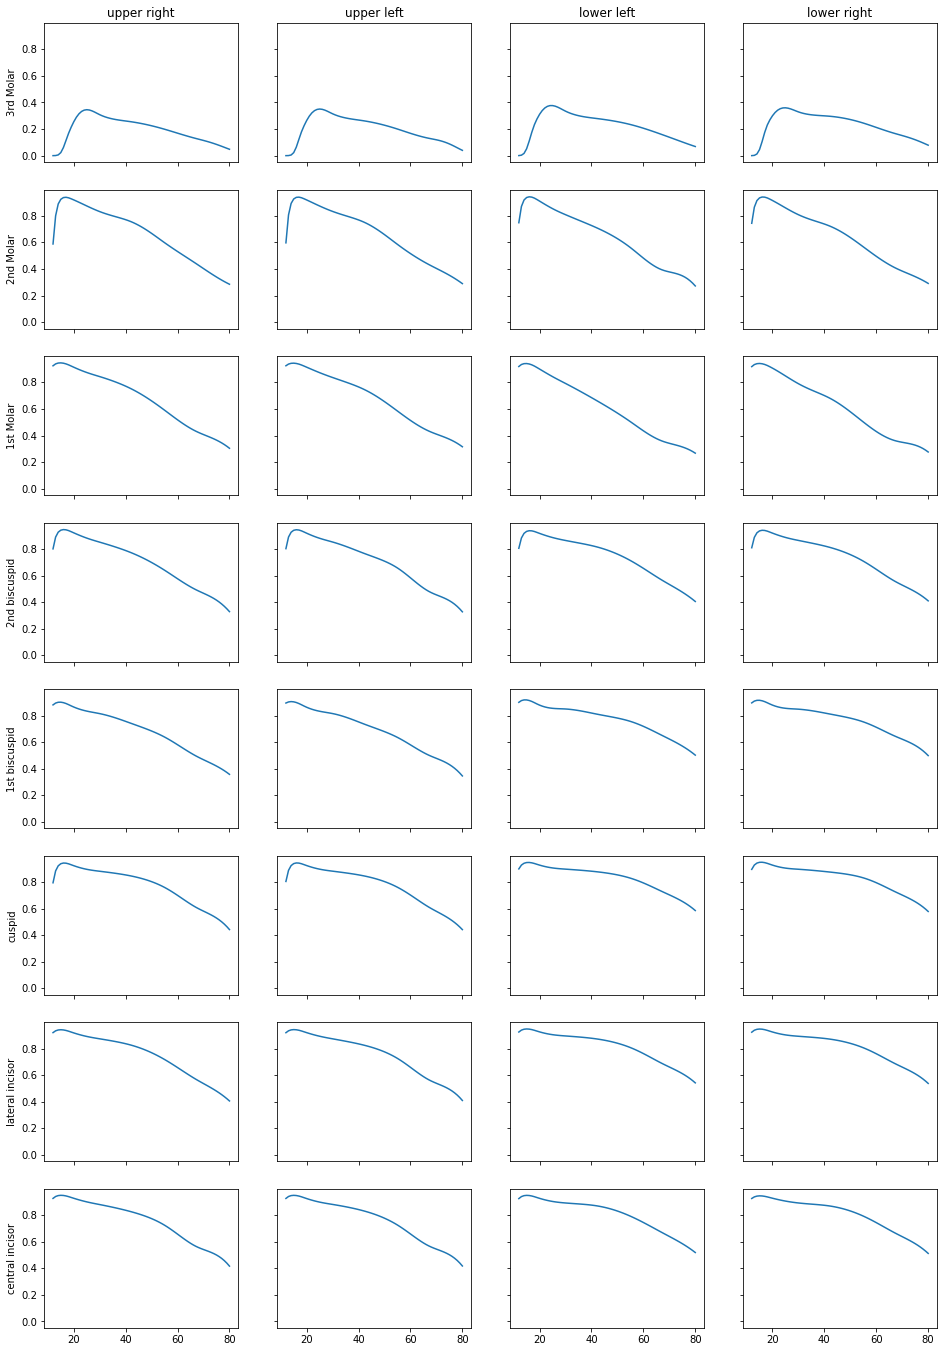

In [16]:
fig, ax = plt.subplots(nrows=8, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(16,24)
for i in range(32):
    r = (position[i] -1)%8
    c = i //8
    
    pred_col = 'tc_' + str(i+1).zfill(2) + 'pred'
    Plot_df = (all_tooth_df[['age', pred_col]]
               .sort_values(by=['age'])
               .drop_duplicates()
              )
    
    x_var = np.array(Plot_df['age'])
    
    y_var = np.array(Plot_df[pred_col])
    ax[r, c].plot(x_var, y_var)
    
    if r == 0:
        ax[r,c].set_title(areas[c])
    if c == 0:
        ax[r,c].set_ylabel(tooth_names[r])

## Question 2 - Hosmer-Lemeshow Calibration Plot [30 points]

In this question you will construct a plot often associated with the Hosmer-Lemeshow goodness-of-fit test. The plot is often used to assess the calibration of a generalized linear models across the range of predicted values. Specifically, it is used to assess if the expected and observed means are approximately equal across the range of the expected mean.

Use the tooth you selected in question 1 part a for this question.

- Split the data into deciles based on the fitted (aka predicted) probabilities your model assigns to each subject’s tooth. The 10 groups you create using deciles should be approximately equal in size.

- Within each decile, compute the observed proportion of cases with a permanent tooth present and the expected proportion found by averaging the probabilities.

In [17]:
df['predict_decile'] = np.multiply(np.round(df['predict'],1),10)
df['predict_decile'] = pd.to_numeric(df['predict_decile'] , downcast='integer')
observed_prop = (
    df
    .groupby('predict_decile')[['tc02_Perm_Pre']]
    .mean()
)

expected_prop = (
    df
    .groupby('predict_decile')[['predict']]
    .mean()
)

In [18]:
observed_prop

,tc02_Perm_Pre
predict_decile,
3,0.306799
4,0.423903
5,0.491974
6,0.577763
7,0.699152
8,0.811183
9,0.900535


In [19]:
expected_prop

,predict
predict_decile,
3,0.307228
4,0.404456
5,0.502650
6,0.598933
7,0.697620
8,0.798816
9,0.903495


- Create a scatter plot comparing the observed and expected probabilities within each decile and add a line through the origin with slope 1 as a guide. Your model is considered well-calibrated if the points in this plot fall approximately on this line.

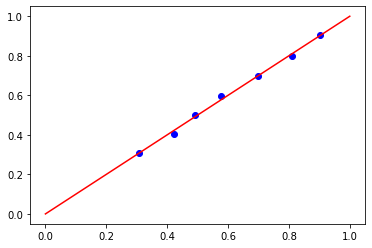

In [20]:
x_var = np.array(observed_prop['tc02_Perm_Pre'])
y_var = np.array(expected_prop['predict'])
plt.scatter(x=x_var, y=y_var, color='blue')
plt.plot([0.0, 1.0], [0.0, 1.0], color='red')

In [21]:
# Calculate the T-test for the means of two independent samples of scores.
p = np.round(ttest_ind(x_var, y_var)[1],4)
p

0.9982

- Briefly comment on how-well calibrated your model is (or is not).

The model is well-calibrated for the sattered points above approximately lie around the line. The p-value for the observed probability and the predicted probability is 0.9982 indicating the well-calibration.